In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext Cython

In [146]:
%%cython
cimport cython
cimport numpy as np
import  numpy as np
from libc.math cimport sqrt


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef int _rotation(double [:,::1] input_data, double [:,::1] output_data,
                 (Py_ssize_t, Py_ssize_t) interval, bint interpolation = 0):
    cdef Py_ssize_t r_len, s_len
    r_len = input_data.shape[1]
    s_len = input_data.shape[0]
    cdef Py_ssize_t r_len_half = r_len // 2
        
    cdef Py_ssize_t yy, xx ,rr
    cdef double radius 
    cdef double summed_line_up, summed_line_down
    cdef double interpolated_value_up, interpolated_value_down
    cdef double value_diff_up, value_diff_down
    
    cdef double* value_1_down
    cdef double* value_1_up
    cdef double* value_2_down
    cdef double* value_2_up
    # no interpolation
    # working on interpolation 
    
    cdef Py_ssize_t offset, loop_start
    if  r_len%2 == 0:
        offset = 1
        loop_start = 0
    else:
        offset = 0
        loop_start = 1
        
        yy = 0
        summed_line_up = 0
        # just the middle line 
        if not interpolation:
            for zz in range(s_len):
                for xx in range(interval[0] - yy, interval[1] , -1):
                    radius = sqrt((yy + 0.25)**2 + (xx - 0.5)**2)
                    rr = int(radius)
                    summed_line_up += (input_data[zz,r_len_half  + rr] 
                                        * (yy + 0.25)/radius)
                output_data[r_len_half - yy ,zz] = summed_line_up
        else:
            for zz in range(s_len):
                for xx in range(interval[0] - yy, interval[1] , -1):
                    radius = sqrt((yy + 0.25)**2 + (xx - 0.5)**2)
                    rr = int(radius)
                    value_1_up = &input_data[zz,r_len_half + rr]
                    if r_len_half - 1 == rr:
                        interpolated_value_up = value_1_up[0]
                    else: 
                        value_2_up = &input_data[zz,r_len_half + rr + 1]
                        value_diff_up = value_2_up[0] - value_1_up[0]
                        interpolated_value_up = (value_1_up[0] + 
                                                     value_diff_up
                                                     * (radius - rr))
                    summed_line_up += (interpolated_value_up
                                       * (yy + 0.25)/radius)
                output_data[r_len_half - yy ,zz] = summed_line_up
            
    if interpolation:
        for zz in range(s_len):
            for yy in range(loop_start, r_len_half):
                summed_line_up = 0
                summed_line_down = 0
                if r_len_half - yy <= interval[0]:
                    x_start  = r_len_half - yy
                else:
                    x_start = interval[0]
                for xx in range(x_start, interval[1] , -1):
                    radius = sqrt((yy + 0.5)**2 + (xx - 0.5)**2)
                    rr = int(radius)
                    value_1_up = &input_data[zz,r_len_half + rr]
                    value_1_down = &input_data[zz, r_len_half - offset - rr]
                    if r_len_half - 1 == rr:
                        interpolated_value_up = value_1_up[0]
                        interpolated_value_down = value_1_down[0]
                    else: 
                        value_2_up = &input_data[zz,r_len_half + rr +1]
                        value_2_down = &input_data[zz,r_len_half  - offset - rr - 1]

                        value_diff_up = value_2_up[0] - value_1_up[0]
                        value_diff_down = value_2_down[0] - value_1_down[0]

                        interpolated_value_up = (value_1_up[0] + 
                                                 value_diff_up
                                                 * (radius - rr))
                        interpolated_value_down = (value_1_down[0] +
                                                   value_diff_down
                                                   * (radius - rr))

                    summed_line_up += (interpolated_value_up 
                                       * (yy + 0.5)/radius)
                    summed_line_down += (interpolated_value_down 
                                         * (yy + 0.5)/radius)
                # multiply with 2 to include the other side (It's identical)
                output_data[r_len_half - offset -yy ,zz] = 2 * summed_line_up
                output_data[r_len_half +  yy, zz]  = 2 * summed_line_down
    else:
        for zz in range(s_len):
            for yy in range(loop_start, r_len_half):
                summed_line_up = 0
                summed_line_down = 0
                if r_len_half - yy <= interval[0]:
                    x_start  = r_len_half - yy
                else:
                    x_start = interval[0]
                for xx in range(x_start, interval[1], -1):
                    radius = sqrt((yy + 0.5)**2 + (xx - 0.5)**2)
                    rr = int(radius)

                    value_1_up = &input_data[zz,r_len_half + rr]
                    value_1_down = &input_data[zz, r_len_half - offset - rr]

                    interpolated_value_up = value_1_up[0]
                    interpolated_value_down = value_1_down[0]

                    summed_line_up += (interpolated_value_up 
                                       * (yy + 0.5)/radius)
                    summed_line_down += (interpolated_value_down 
                                         * (yy + 0.5)/radius)
                # multiply with 2 to include the other side (It's identical)
                output_data[r_len_half - offset -yy ,zz] = 2 * summed_line_up
                output_data[r_len_half +  yy, zz]  = 2 * summed_line_down

    return loop_start

def rotation(input_data, interpolation = False):
    try:
        input_data.flags
    except AttributeError:
        print('input_data should be a numpy array!')
        raise
    if input_data.flags['F_CONTIGUOUS']:
        print('input_data should be stored in a raw major, C contigous.')
    elif not input_data.flags['C_CONTIGUOUS']:
        print('input_data as to be a contigous array.')
    
    if input_data.dtype != np.float64:
        print('input should be an ndarray of type np.float64.')
        print('Converting to float64 and continuing...')
        input_data = input_data.astype(np.float64)

    output = np.zeros(input_data.size, dtype=np.float64, order='C').reshape(
                    input_data.shape[1], input_data.shape[0])
    
    cdef double [:,::1] input_data_view = input_data
    cdef double [:,::1] output_view = output
    # returned_status just for debugging, flow control. To be removed!
    returned_status = _rotation(input_data_view, output_view, interpolation)
    print(returned_status)
    return output

def rotation_timeresolved( steps, intervals, interpolation = False):
    if not len(steps) == len(intervals):
        return 1 #rise an expt
    cdef double [:,::1] step_view
    output = np.zeros(steps[0].size, dtype=np.float64,
                      order = "C").reshape(steps[0].shape[1], steps[0].shape[0])
    end_output = np.zeros_like(output)
    for ii in range(len(steps)):
        try:
            steps[ii].flags
        except AttributeError:
            print('input_data should be a numpy array!')
            raise
        if steps[ii].flags['F_CONTIGUOUS']:
            print('input_data should be stored in a raw major, C contigous.')
        elif not steps[ii].flags['C_CONTIGUOUS']:
            print('input_data as to be a contigous array.')

        if steps[ii].dtype != np.float64:
            print('input should be an ndarray of type np.float64.')
            print('Converting to float64 and continuing...')
            input_data = steps[ii].astype(np.float64)
        step_view  = steps[ii]
        _rotation(steps[ii], output, intervals[ii], interpolation)
        end_output += output
    return end_output

In [5]:
path = '../../Faraday_Rotation/test_samples/'

In [6]:
file_name = 'sim'

In [122]:
test_sample = np.load(path + file_name + '.npy')
test_sample = np.ascontiguousarray(test_sample[::-1,:], dtype=np.float64)

In [123]:
test_sample2 = np.load(path + 'sim2' + '.npy')
test_sample2 = np.ascontiguousarray(test_sample2[::-1,:], dtype=np.float64)

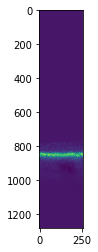

In [8]:
plt.imshow(test_sample)

In [124]:
test_sample2.shape

(1280, 256)

In [148]:
rotated = rotation_timeresolved([test_sample, test_sample2], [(256, 150), (150,0)])

In [149]:
rotated

array([[-7.36443612e+29, -1.17156681e+31, -7.72374954e+30, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.07726979e+29, -7.23493598e+29, -6.33709881e+30, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.18772512e+27, -2.83731356e+29, -3.02613558e+29, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  2.58144837e+27, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.94348471e+30, -1.57212426e+30,  1.49106941e+30, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.72236432e+30, -3.87616205e+30, -1.15476817e+30, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

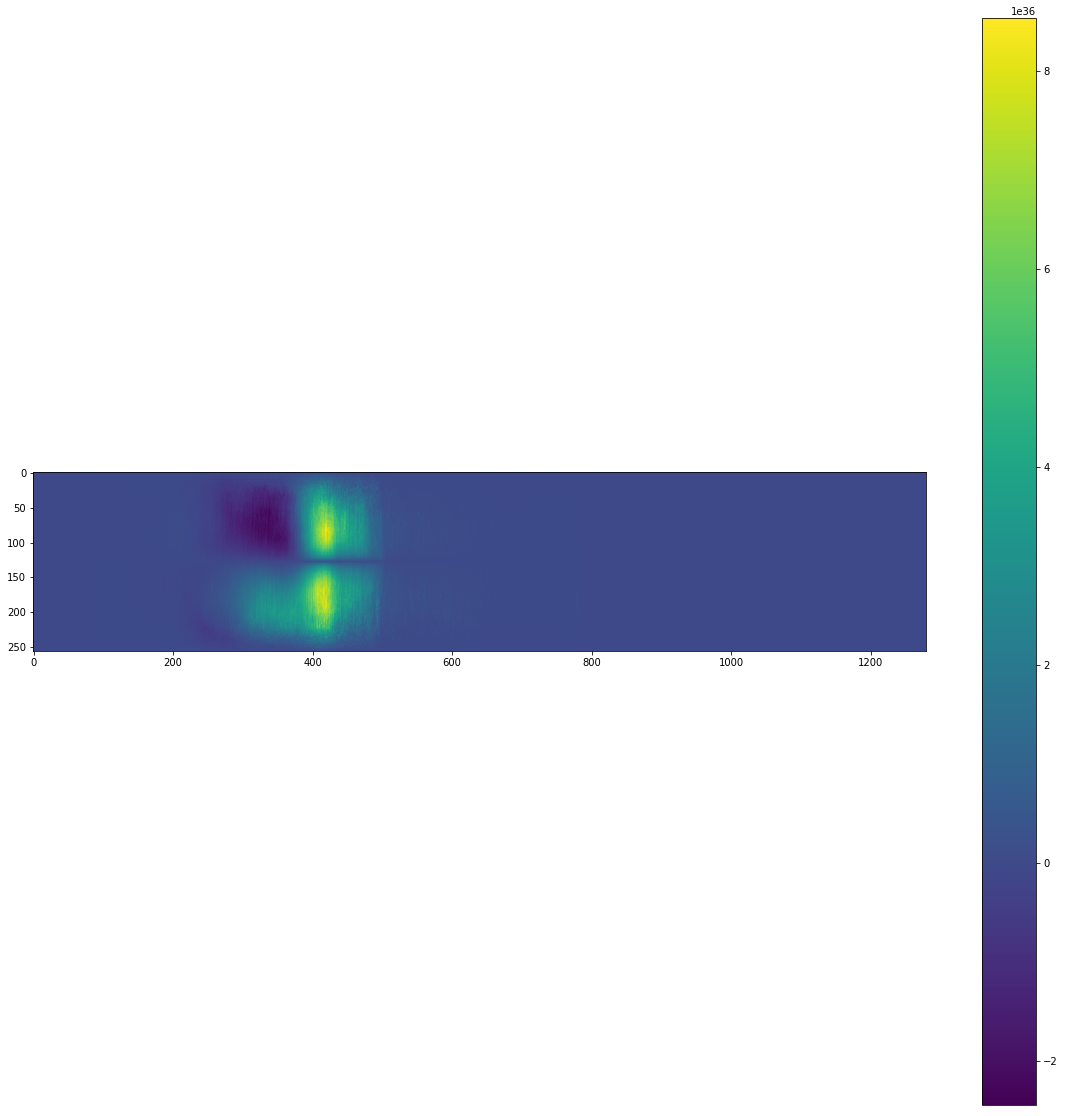

In [150]:
f, ax = plt.subplots(1, figsize=(20,20))
ax.imshow(rotated)
f.colorbar(ax.images[0])
#f.savefig('w_int.jpg')